# Quick tour of OpenVisus in python


### Define some utility functions:

In [1]:
import os,sys

# Here are commands to install a package (OpenVisus) directly from a jupyter notebook
# after you install those once you can comment those comment
# !{sys.executable} -m pip install numpy matplotlib OpenVisus

In [2]:
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import shutil

def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))

def ShowImage(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()

### First import OpenVisus

In [3]:
sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

### Create an empty RGB dataset

In [4]:
idx_filename='tmp/quick_tour/visus.idx'
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)
CreateIdx(url=idx_filename, dim=3, dims=[1025,512,256],fields=[Field('data','uint8[3]','row_major')])
assert(os.path.isfile(idx_filename))

### Create a 2d dataset from numpy array

In [5]:
idx_filename='tmp/quick_tour/visus.idx'
data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/gray.png')
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)
CreateIdx(url=idx_filename, dim=2, data=data)
assert(os.path.isfile(idx_filename))

### Create a 3d dataset from numpy array

In [6]:
data=numpy.zeros((100,100,100,3),dtype=numpy.float32) 
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)
CreateIdx(url=idx_filename, dim=3, data=data)
assert(os.path.isfile(idx_filename))

### Create a 3d datasets from 2d slices

In [7]:
data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/rgb.png')
height,width=data.shape[0],data.shape[1]

# replicate one 2d images 10 times
depth=10

def generateSlices():
    for I in range(depth): 
        yield data

shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)    
db=CreateIdx(url=idx_filename, dims=[width,height,depth],fields=[Field('data','uint8[3]','row_major')])
db.writeSlabs(generateSlices())

### Read a single slice

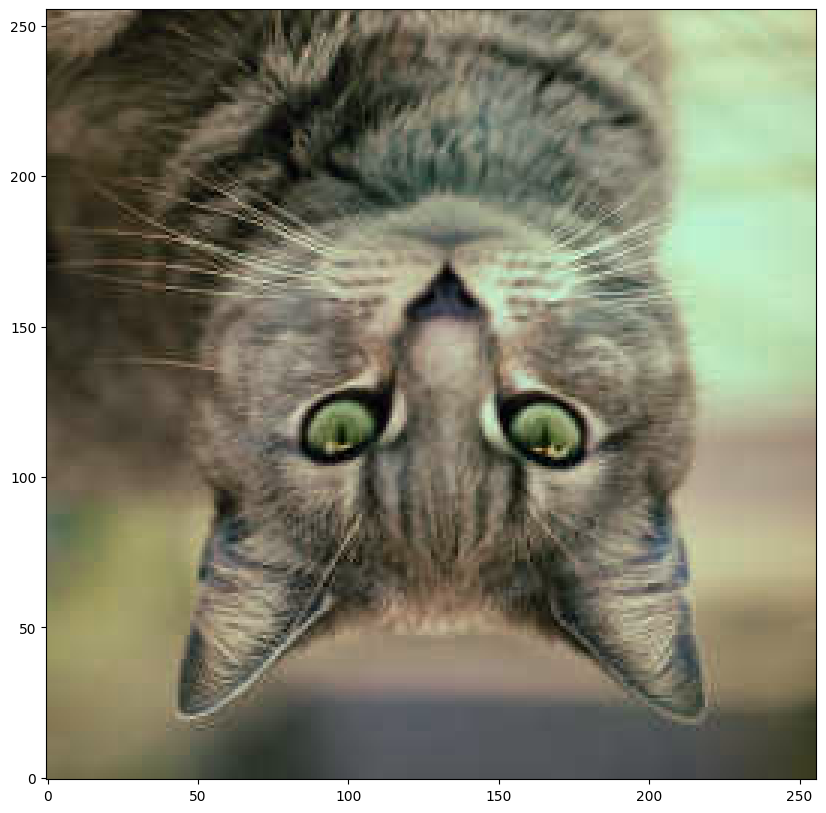

In [8]:
data=db.read(z=[0,1])[0,:,:]
ShowImage(data)

### Read stuff in one shot at full resolution

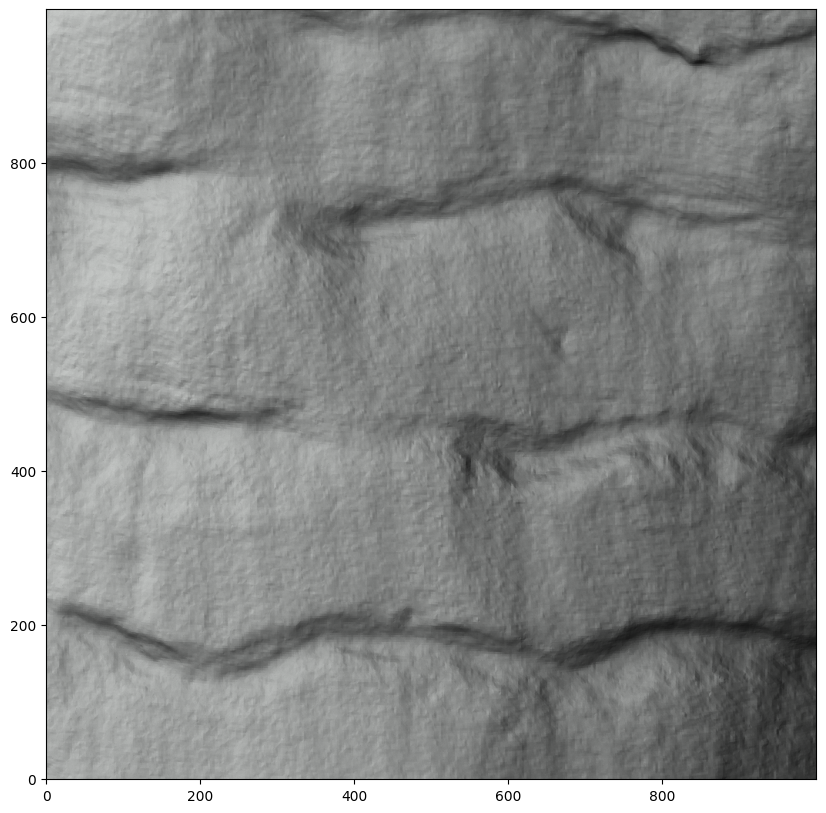

In [9]:
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled')
data=db.read(x=[10000,11000],y=[10000,11000])
ShowImage(data)

### Show image coarse to fine

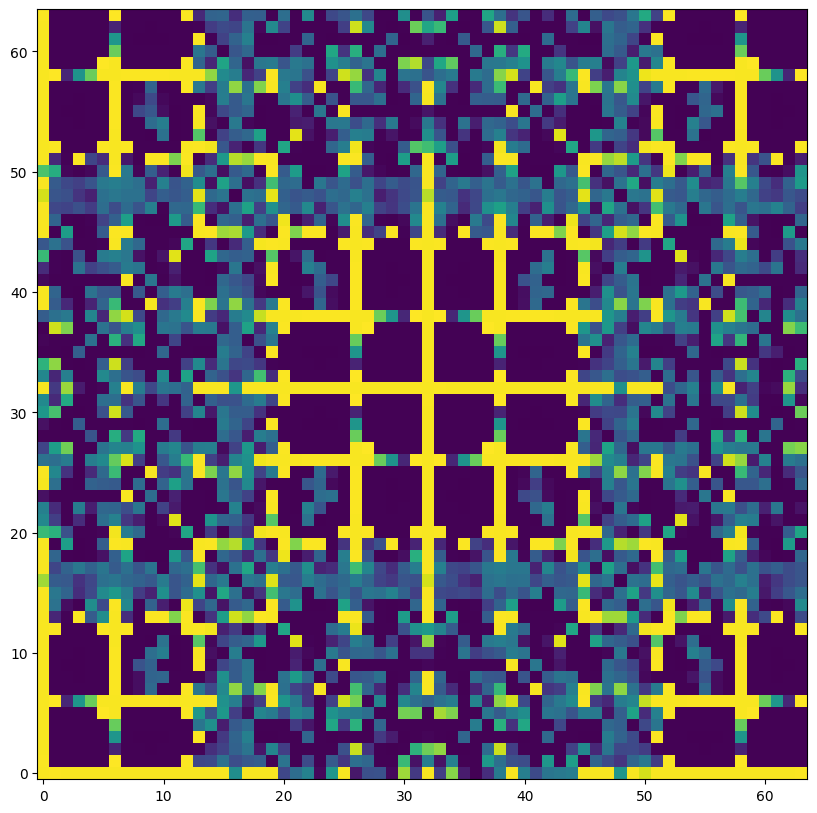

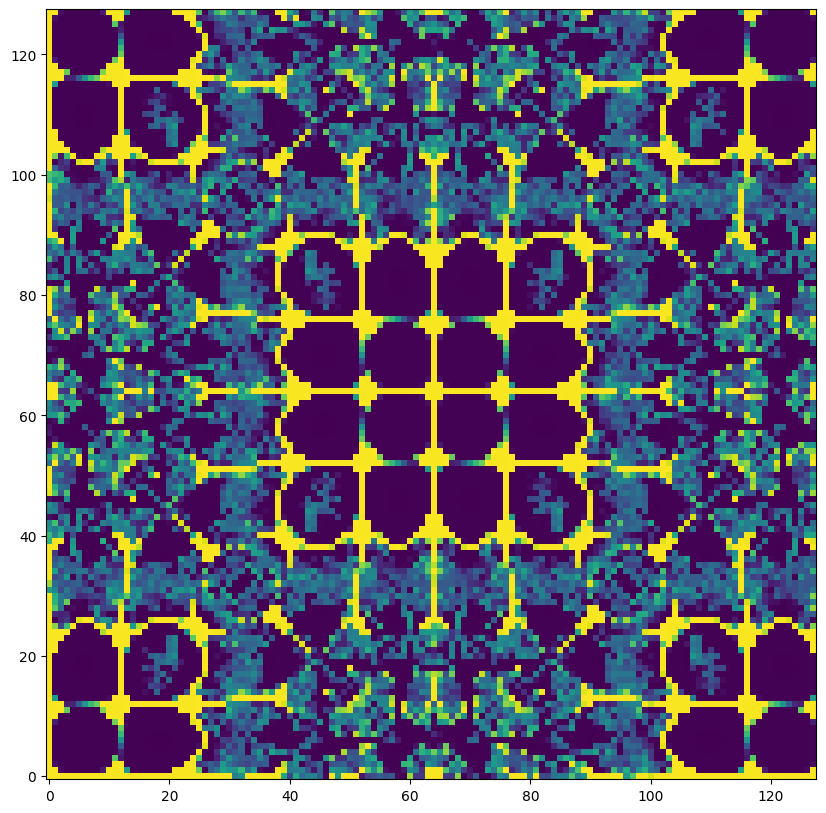

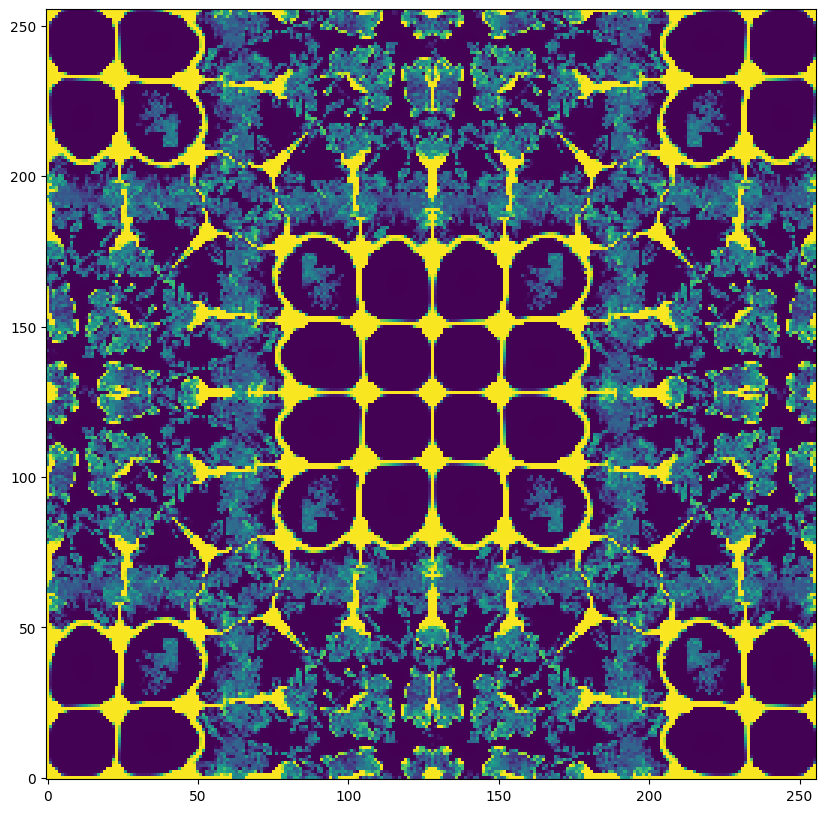

In [13]:
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1')
for data in db.read(x=[0,2048],y=[0,2048],z=[1024,1025], num_refinements=3, quality=-9):
    ShowImage(data[0,:,:])

### Get data in normalized coordinates

(440, 183, 3) uint8


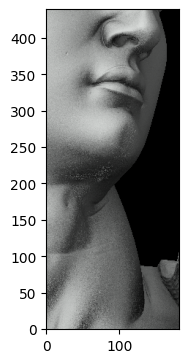

In [11]:
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled')
data=db.read(x=[0.35,0.45],y=[0.8,0.9],quality=-8)
print(data.shape,data.dtype)
ShowImage(data)

### Start a local visus server for one dataset

In [12]:
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True) 
CreateIdx(
    url=idx_filename, 
    dim=2,
    blockperfile=-1,
    filename_template="./visus.bin", 
    data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/rgb.png'))

modvisus = ModVisus()
modvisus.configureDatasets(ConfigFile.fromString('''
<visus>
  <datasets>
    <dataset name='default' url='tmp/quick_tour/visus.idx' permissions='public' />
  </datasets>
</visus>
'''))
port=10000 # configure port as needed
server=NetServer(port, modvisus)
server.runInBackground()

# check the server is running in the background
body=urlopen('http://127.0.0.1:{}/mod_visus?action=read_dataset&dataset=default'.format(port)).read().decode('utf8')
print(body)

# kill the server
server.signalExit()
server.waitForExit()
print('server done')

(version)
6
(box)
0 255 0 255
(fields)
DATA uint8[3] default_compression(zip) default_layout() default_value(0) min(0 0 0) max(0 0 0) 
(bits)
V0101010101010101
(bitsperblock)
16
(blocksperfile)
1
(interleave block)
0
(filename_template)
./visus.bin
(missing_blocks)
0
(arco)
0

server done
